# Calibration of missing proxy records

**First look at notebook historical_data_analysis.ipynb**

Following Raphael Neukoms review of the manuscript and our reply (https://egusphere.copernicus.org/preprints/2024/egusphere-2024-545/), historical records could be added to our collection of proxy records via a calibration to instrumental temperature and precipitation, though not a big impact on the reconstruction is expected (see review reply for detailed discussion).

In this notebook we:
   - preprocess the historical data into a useful format + give it a location
   - perform linear regressions temperature, precipitation, spei as for tree rings for the annual and seasonal means
   - put the 
   
We also perform a regression for the lake puyehue record and add it to the file with lake records

In [2]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import numpy as np
import xarray as xr
import scipy as sc
import pickle
import lipd
import urllib

import cftime
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature  

import os
import matplotlib as mpl
from adjustText import adjust_text
from scipy import stats
import xskillscore

pd.set_option('display.max_rows', 700,'display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 700,'display.max_columns', None)


%load_ext autoreload
%autoreload 2
%matplotlib inline

def mean(xarray,avg):
    """
    TAKE ANNUAL/SEASONAL MEAN
    """
    fm=xarray.time.dt.month[0]
    years=np.unique(xarray.time.dt.year.values)
    try:
        sm=avg[0]
    except:
        sm=avg

    #first month in Array smaller than start month: slice from avg-month in first year
    if fm<=sm:
        xarray=xarray.isel(time=slice(int(sm-fm),None))
        #print('slice in first year')
    #slice in second year
    else:
        xarray=xarray.isel(time=slice(int(12-fm+sm),None))
        #print('slice in second year')
    #"""
    lm=xarray.time.dt.month[-1].values

    if isinstance(avg,np.ndarray) | isinstance(avg,list):
        #month to end with
        em=avg[-1]
        #slice in last year
        if lm>em:
            #if last month in prior larger than end month in avg slice from the end
            xarray=xarray.isel(time=slice(None,int(em-lm)))
        elif lm<em:
            #else go one year further back
            xarray=xarray.isel(time=slice(None,int(em-lm-12)))

        #xarray=xarray.resample(time='1MS').mean()
        #xarray=xarray.where(xarray.time.dt.month.isin(avg), drop=True)
        if len(xarray.dims)>1:
            xarray=xarray[xarray.time.dt.month.isin(avg),:,:] #(where extremely slow)
        else:
            xarray=xarray[xarray.time.dt.month.isin(avg)]
        calib_data1=xarray.coarsen(time=len(avg),boundary='trim').sum('time')    

    elif isinstance(avg,int): 
        #slice in last year
        if lm>=avg:
            xarray=xarray.isel(time=slice(None,int(avg-lm-1)))
        else:
            xarray=xarray.isel(time=slice(None,int(avg-lm-12-1)))
    
    calib_data1=xarray.resample(time="12MS",closed='left',label='left').mean()
    return calib_data1


In [3]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

## Load a calibrated proxy dataset for knowing structure of future netcdf-file

In [24]:
example=xr.open_dataset('/data/projects/Mathi_paper/zenodo_paper/input_data/proxy_data/trees_best_ann.nc')
lakes=xr.open_dataset('/data/projects/Mathi_paper/zenodo_paper/input_data/proxy_data/lakes.nc')

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/l

In [25]:
lakes

<xarray.Dataset>
Dimensions:                        (time: 2015, site: 6)
Coordinates: (12/14)
  * time                           (time) object 0001-01-01 00:00:00 ... 2015...
    archiveType                    (site) object ...
    geo_siteName                   (site) object ...
    pub1_doi                       (site) object ...
    geo_meanLat                    (site) float64 ...
    geo_meanLon                    (site) float64 ...
    ...                             ...
    paleoData_variableName         (site) object ...
    PSM                            (site) object ...
    seasonality                    (site) object ...
    variable_name                  (site) object ...
    noise_snr                      (site) object ...
    regression_params_var          (site) object ...
Dimensions without coordinates: site
Data variables:
    __xarray_dataarray_variable__  (time, site) float64 ...

In [26]:
list(example.coords)

['time',
 'paleoData_variableName',
 'archiveType',
 'geo_meanLat',
 'geo_meanLon',
 'geo_siteName',
 'minYear',
 'maxYear',
 'pub1_doi',
 'PSM',
 'variable_name',
 'noise_snr',
 'regression_params_a',
 'regression_params_b',
 'regression_params_var',
 'seasonality']

In [27]:
for c in list(lakes.coords):
    if c!='time':
        print(c)
        print(lakes[c].values)
        print('')

archiveType
['lake sediment' 'lake sediment' 'lake sediment' 'lake sediment'
 'lake sediment' 'lake sediment']

geo_siteName
['Lago El Grancho' 'Laguna Pumacocha' 'Laguna Chepical' 'Laguna Aculeo'
 'Laguna Escondida' 'Lago Plomo']

pub1_doi
['10.1130/G33736.1' '10.1016/j.epsl.2011.08.040' '10.5194/cp-9-1921-2013'
 '10.1177/0959683609336573' '10.1016/j.palaeo.2012.11.013'
 '10.1016/j.quaint.2015.01.004']

geo_meanLat
[ 11.9    -10.7    -32.2667 -33.85   -45.5167 -46.9833]

geo_meanLon
[274.0833 283.94   289.5    289.08   288.1833 287.1333]

minYear
[  341.    -276.39 -1161.     856.     400.    1384.  ]

maxYear
[2004. 2007. 2005. 1997. 2008. 2001.]

paleoData_variableName
['d18O' 'd18O' 'tsurf' 'tsurf' 'tsurf' 'tsurf']

PSM
['inf_weighted' 'inf_weighted' 'season' 'season' 'None' 'season']

seasonality
['None' 'None' '11,12,1,2' '12,1,2' 'Annual' '9,10,11,12,1,2']

variable_name
['d18O' 'd18O' 'tsurf' 'tsurf' 'tsurf' 'tsurf']

noise_snr
['assumed' 'assumed' 'assumed' 'assumed' 'assumed'

In [28]:
for c in list(example.coords):
    if 'reg' in c or 'snr' in c or 'season' in c or 'PSM' in c or 'variable' in c:
        print(c)
        print(example[c].values[:4])
        print('')

paleoData_variableName
['trw' 'trw' 'trw' 'trw']

PSM
['linear' 'linear' 'linear' 'linear']

variable_name
['prec' 'prec' 'prec' 'prec']

noise_snr
[0.37229449 0.31851044 0.24512083 0.49026821]

regression_params_a
[ 0.02358746 -0.04089461 -0.04430122 -0.0820154 ]

regression_params_b
[-1.42933463 -0.18579763  0.20755508  1.69391185]

regression_params_var
[1.21740706 0.61212574 0.61450246 0.87385267]

seasonality
['None' 'None' 'None' 'None']



In [29]:
lakes['archiveType'].values

array(['lake sediment', 'lake sediment', 'lake sediment', 'lake sediment',
       'lake sediment', 'lake sediment'], dtype=object)

In [30]:
lakes

<xarray.Dataset>
Dimensions:                        (time: 2015, site: 6)
Coordinates: (12/14)
  * time                           (time) object 0001-01-01 00:00:00 ... 2015...
    archiveType                    (site) object 'lake sediment' ... 'lake se...
    geo_siteName                   (site) object 'Lago El Grancho' ... 'Lago ...
    pub1_doi                       (site) object '10.1130/G33736.1' ... '10.1...
    geo_meanLat                    (site) float64 11.9 -10.7 ... -45.52 -46.98
    geo_meanLon                    (site) float64 274.1 283.9 ... 288.2 287.1
    ...                             ...
    paleoData_variableName         (site) object 'd18O' 'd18O' ... 'tsurf'
    PSM                            (site) object 'inf_weighted' ... 'season'
    seasonality                    (site) object 'None' ... '9,10,11,12,1,2'
    variable_name                  (site) object 'd18O' 'd18O' ... 'tsurf'
    noise_snr                      (site) object 'assumed' ... 'assumed'
    regression_params_var          (site) object 'None' 'None' ... 'None' 'None'
Dimensions without coordinates: site
Data variables:
    __xarray_dataarray_variable__  (time, site) float64 ...

In [31]:
#CALIBRATION DATASETS

be='/home/mchoblet/validation_data/sa_project/upsampled/be.nc' #change time name!, temperature
be=xr.open_dataset(be)
#be['time']=xr.cftime_range('1850',periods=2079,freq='1M',calendar='standard')#['temperature']
be=be.sel(time=slice('1920','2015'))['temperature']
calib_dic={'Annual':mean(be,4),'DJF':mean(be,[12,1,2]),'JJA':mean(be,[6,7,8])}

#precipitation data set
cru='/home/mchoblet/validation_data/sa_project/upsampled/cru_prec.nc'
cru=xr.open_dataset(cru)['pre'].sel(time=slice('1950','2015'))
calib_dic_cru={'Annual':mean(cru,4),'DJF':mean(cru,[12,1,2]),'JJA':mean(cru,[6,7,8])}

spei_12_th='/home/mchoblet/validation_data/sa_project/spei12.nc'

"""
SPEI DATASET COMPUTED PREVIOUSLY FROM HADCRUT DATA (SEE SPEI NOTEBOOK)
"""

spei_ann=xr.open_dataset('/home/mchoblet/validation_data/sa_project/upsampled/spei_ann.nc').sel(time=slice('1920','2015'))
spei_jja=xr.open_dataset('/home/mchoblet/validation_data/sa_project/upsampled/spei_jja.nc').sel(time=slice('1920','2015'))
spei_djf=xr.open_dataset('/home/mchoblet/validation_data/sa_project/upsampled/spei_djf.nc').sel(time=slice('1920','2015'))

calib_dic_spei={'Annual':spei_ann['spei'],'DJF':spei_djf['spei'],'JJA':spei_jja['spei']}

for k,v in calib_dic_spei.items():
    calib_dic_spei[k]=v-v.sel(time=slice('1950','2000')).mean('time')


# Lago Puyehue

https://sci-hub.se/10.1007/s10933-007-9119-9

https://doi.org/10.25921/c12j-xt11

Data taken from  Neukom Gergis 2012:
 Southern Hemisphere high-resolution palaeoclimate records of the last 2000 years. 
https://doi.org/10.1177/0959683611427335


* Perform regression for the shorter period (1980 - 2000) as in the original paper to see that precipitation values are similar (though for longer period you will see that the regression is worse). It is not clear if the local precipitation dataset only started in 1980 or they would have had longer local datasets).

In [32]:
df2 = pd.read_csv('/home/mchoblet/historical_data/Proxies_SH_recon_unscreened.csv', sep=';')
df2.set_index(df2.columns[0], inplace=True)
df2 = df2.iloc[1:]
df2.index.name = 'Year CE'
ds2 = xr.Dataset.from_dataframe(df2)

In [33]:
puyehue=ds2['Lago Puyehue']

In [34]:
lakes_copy=lakes.copy(deep=True)

In [35]:
# New site coordinates
new_site_coords = {
    "time": xr.cftime_range(start='0001',end='2009',freq='YS'),
    "archiveType": 'lake sediment',
    "geo_siteName": 'Lago Puyehue',
    "pub1_doi": 'doi.org/10.25921/c12j-xt11',
    "geo_meanLat": -40.65,
    "geo_meanLon": 360-72.45,
    "minYear": 1408,
    "maxYear": 1997,
    "paleoData_variableName": 'Varve thickness',
    "PSM": 'TBD',
    "seasonality": 'TBD',
    "variable_name": 'TBD',
    "noise_snr": 'TBD',
    "regression_params_var": 'TBD',
}

In [36]:
puyehue_ds = xr.Dataset(
    {
        "values": (["time"], puyehue.values)
    },
    coords=new_site_coords)

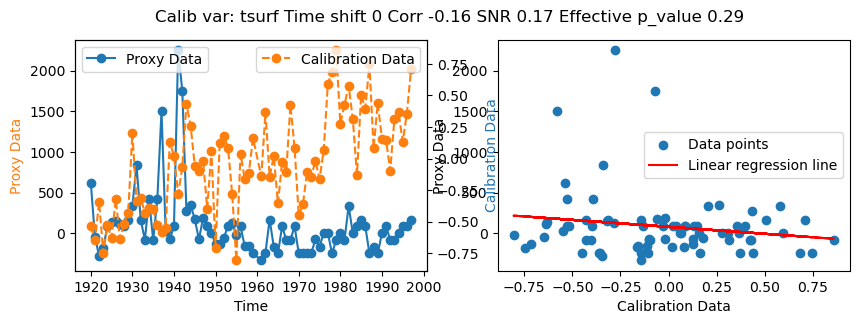

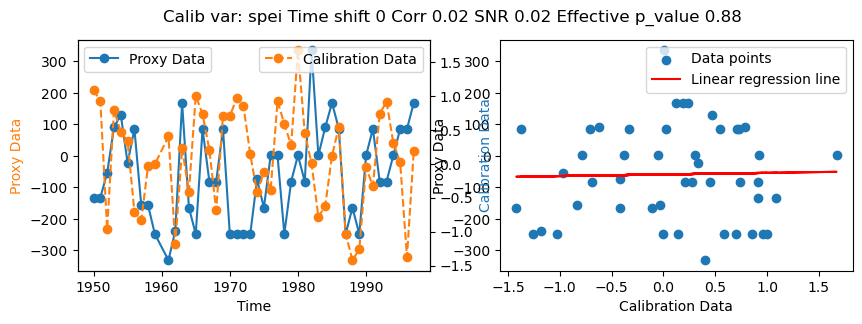

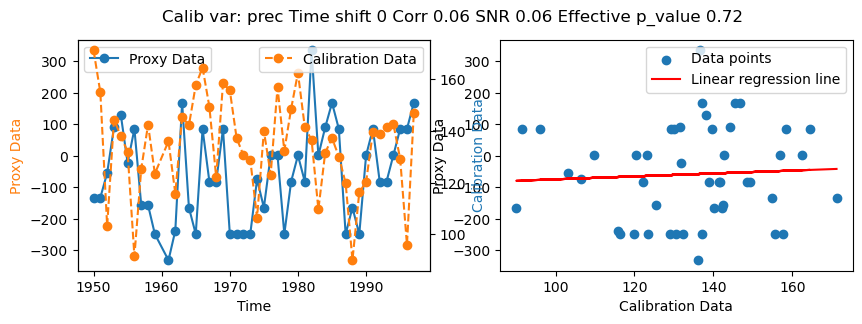

Annual tsurf -0.16117667512272726 0.16547538144372562


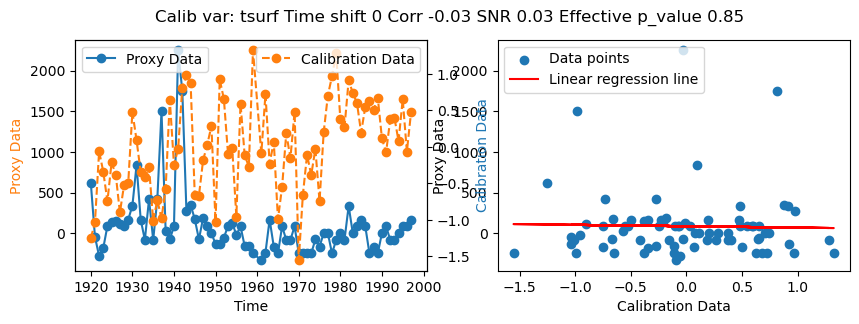

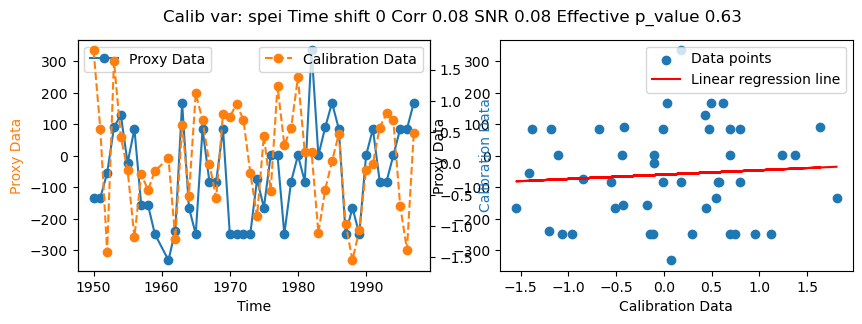

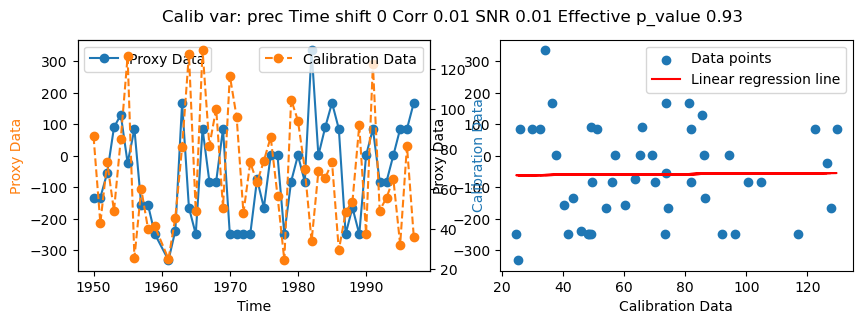

DJF spei 0.07575696589202134 0.0761942536958492


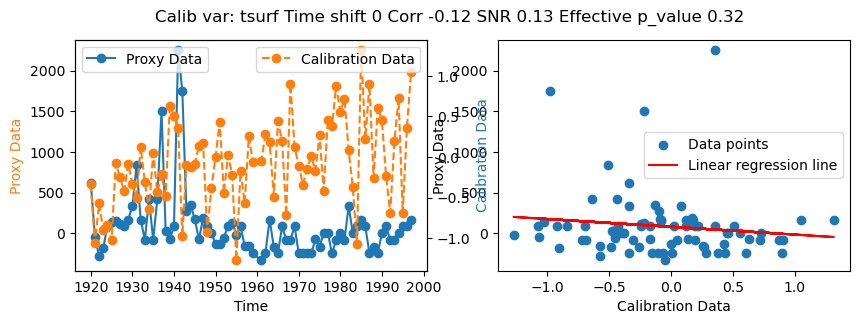

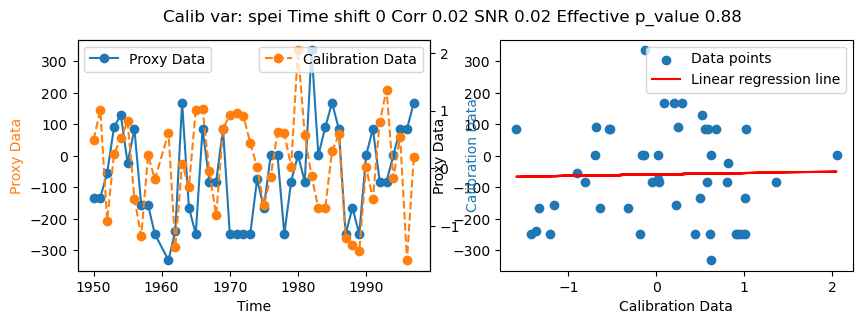

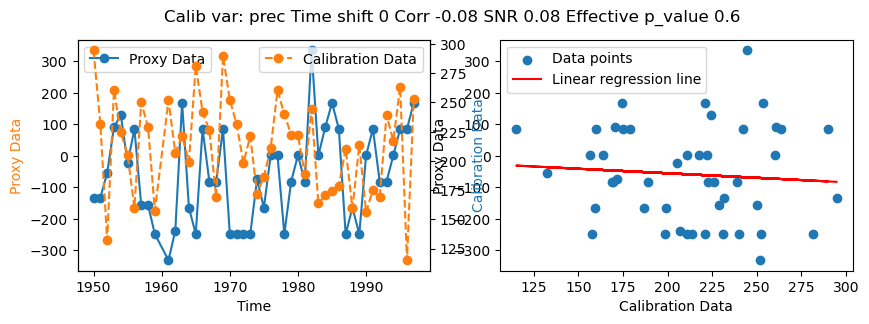

JJA tsurf -0.12460333469749103 0.1265684350837298


In [37]:
# Run calibration for each season and different variables
t_calib = [['1920', '2015'], ['1950', '2015'], ['1950', '2015']]

#short calibration periods as in original paper: (use windows above for consistency!)
#t_calib = [['1980', '2015'], ['1980', '2015'], ['1980', '2015']]

dicts = {'tsurf': calib_dic, 'spei': calib_dic_spei, 'prec': calib_dic_cru}

proxy = puyehue_ds['values']

calibs=[]
cal_vars=[]

# Demean the proxy records with respect to one joint time frame
proxy = proxy - proxy.sel(time=slice('1750', '1850')).mean('time')
fit_params = {}
#shift = [-1, 0]  # Shift the calibration year either by -1 or 0 (due to the fact that proxy year might mismatch by one. Thought also about +1, but I don't think it fits).
shift=[0]

for ii, kk in enumerate(['Annual', 'DJF', 'JJA']):
    psl = []
    fit_params = []
    vals_l = []
    proxy_l = []
    
    for jj, (var, calib_d) in enumerate(dicts.items()):
        proxy2 = proxy.sel(time=slice(t_calib[jj][0], t_calib[jj][1])) 
        # Select calibration values for nearby gridcell
        try:
            c = calib_d[kk].sel(latitude=proxy['geo_meanLat'].values.item(), longitude=proxy['geo_meanLon'].values.item(), method='nearest')
        except:
            c = calib_d[kk].sel(lat=proxy['geo_meanLat'].values.item(), lon=proxy['geo_meanLon'].values.item(), method='nearest')
                
        c = c.resample(time='YS').mean()
        c = c.sel(time=slice(t_calib[jj][0], t_calib[jj][1]))
            
        if len(c[~np.isnan(c.values)]) < 5:
            # Something is wrong then
            import pdb
            pdb.set_trace()
                
        # Reindex proxy to fill nans at the end
        proxy2 = proxy2.resample(time='YS').mean()
        corrs = []
        ps = []
        lis = []
        vals = []
        proxy_vals = []

        # Compute correlations for shifts
        for t_shift in shift:
            c2 = c.shift(time=t_shift)
            proxy3 = proxy2.reindex(time=c2['time'])
            proxy3 = proxy3.resample(time='YS').mean()  # Needed to fill some nans eventually

            # Check for nans in the calibration data and proxy
            proxy3 = proxy3[~np.isnan(c2)]
            c2 = c2[~np.isnan(c2)]
            c2 = c2[~np.isnan(proxy3)]
            proxy3 = proxy3[~np.isnan(proxy3)]
            
            #standardize (only for nicer plots)
            #c2=(c2-np.mean(c2))/np.std(c2)
            #proxy3=(proxy3-np.mean(proxy3))/np.std(proxy3)
            
            slope, intercept, r, p, se = stats.linregress(c2.values, proxy3.values)
            # Got the error wrong initially, se is not the error I'm looking for!
            # I need the variance of the residuals, thus
            err = np.mean((proxy3.values - c2.values * slope - intercept) ** 2)
            li = [r, p, slope, intercept, len(c2.values), err]

            corrs.append(r)
            lis.append(li)
            vals.append(c2.values)
            proxy_vals.append(proxy3.values)
            ps.append(xskillscore.pearson_r_eff_p_value(proxy3, c2).values.tolist())  # Compute effective p value
            
            # Create the subplots
            fig, ax1 = plt.subplots(1, 2, figsize=(10, 3))

            # Plot the evolution of the proxy and calibration data on the first subplot
            ax1[0].plot(proxy3['time'], proxy3,'o-', label='Proxy Data', c='tab:blue')
            ax2 = ax1[0].twinx()
            ax2.plot(c2['time'], c2,'o--', label='Calibration Data', c='tab:orange')

            # Add labels and legends
            ax1[0].set_xlabel('Time')
            ax1[0].set_ylabel('Proxy Data', color='tab:orange')
            ax2.set_ylabel('Calibration Data', color='tab:blue')
            ax1[0].legend(loc='upper left')
            ax2.legend(loc='upper right')

            # Scatter plot with linear regression line on the second subplot
            ax1[1].scatter(c2, proxy3, color='tab:blue', label='Data points')
            ax1[1].plot(c2, slope * c2 + intercept, color='red', label='Linear regression line')

            # Add labels and legends
            ax1[1].set_xlabel('Calibration Data')
            ax1[1].set_ylabel('Proxy Data')
            ax1[1].legend()

            # Title for the plots
            value=xskillscore.pearson_r_eff_p_value(proxy3, c2).values.tolist()
            snr = np.abs(r) / (1 - np.abs(r) ** 2)
            fig.suptitle('Calib var: {} Time shift {} Corr {} SNR {} Effective p_value {}'.format(var,t_shift,np.round(r,2),np.round(snr,2),np.round(value,2) ))

            # Show the plots
            plt.show()
            
                
        # For each season, select the better correlation values according to the smaller p-value
        iii = np.argmin(ps)
        psl.append(ps[iii])  # Append best p value
        fit_params.append(lis[iii])
        vals_l.append(vals[iii])
        proxy_l.append(proxy_vals[iii])
        
    # Find best match
    iii = np.argmin(psl)
    a = fit_params[iii][2]
    b = fit_params[iii][3]
    r = fit_params[iii][0]
    var = fit_params[iii][-1]
        
    snr = np.abs(r) / (1 - np.abs(r) ** 2)
    
    print(kk,['tsurf','spei','prec'][iii],r, snr)
    
    calibs.append([a, b, snr, var])
    cal_vars.append(list(dicts.keys())[iii])
    
    """
    calibs[ii, j, :] = [a, b, snr, var]
    cal_vars[ii, j] = list(dicts.keys())[iii]
    print(i['geo_siteName'], np.round(fit_params[iii][0], 2), np.round(snr, 2), list(dicts.keys())[iii])
    print(np.round(fit_params[iii][0], 2), np.round(fit_params[iii][1], 2))
    """

In [38]:
lakes_copy=lakes.copy(deep=True)

lakes_ann=lakes.copy(deep=True)['__xarray_dataarray_variable__']
lakes_djf=lakes.copy(deep=True)['__xarray_dataarray_variable__']
lakes_jja=lakes.copy(deep=True)['__xarray_dataarray_variable__']

lakes_ann['regression_params_a']=('site',[np.nan]*6)
lakes_djf['regression_params_a']=('site',[np.nan]*6)
lakes_jja['regression_params_a']=('site',[np.nan]*6)
lakes_ann['regression_params_b']=('site',[np.nan]*6)
lakes_djf['regression_params_b']=('site',[np.nan]*6)
lakes_jja['regression_params_b']=('site',[np.nan]*6)
lakes_ann['regression_params_var']=('site',[np.nan]*6)
lakes_djf['regression_params_var']=('site',[np.nan]*6)
lakes_jja['regression_params_var']=('site',[np.nan]*6)

In [39]:
proxy['variable_name']=cal_vars[0]
proxy['seasonality']='None'
proxy['noise_snr']=calibs[0][2].astype(str) #for saving mixed structure
proxy['regression_params_a']=calibs[0][0]
proxy['regression_params_b']=calibs[0][1]
proxy['regression_params_var']=calibs[0][3]
lakes_ann=xr.concat([lakes_ann,proxy],dim='site')

proxy['variable_name']=cal_vars[1]
proxy['seasonality']='12,1,2'
proxy['noise_snr']=calibs[1][2].astype(str)
proxy['regression_params_a']=calibs[1][0]
proxy['regression_params_b']=calibs[1][1]
proxy['regression_params_var']=calibs[1][3]
lakes_djf=xr.concat([lakes_djf,proxy],dim='site')

proxy['variable_name']=cal_vars[2]
proxy['seasonality']='6,7,8'
proxy['noise_snr']=calibs[2][2].astype(str)
proxy['regression_params_a']=calibs[2][0]
proxy['regression_params_b']=calibs[2][1]
proxy['regression_params_var']=calibs[2][3]
lakes_jja=xr.concat([lakes_jja,proxy],dim='site')

In [40]:
%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_djf.nc'
%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_ann.nc'
%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_jja.nc'

In [41]:
lakes_ann=lakes_ann.to_dataset()
lakes_djf=lakes_djf.to_dataset()
lakes_jja=lakes_jja.to_dataset()

In [42]:
lakes_ann.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_ann.nc')
lakes_djf.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_djf.nc')
lakes_jja.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_jja.nc')

In [17]:
#separate the single record, because else something goes wrong when "equal variance" mode is used.
ann=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_ann.nc')
djf=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_djf.nc')
jja=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/lakes_jja.nc')

ann=ann.isel(site=[6])
djf=djf.isel(site=[6])
jja=jja.isel(site=[6])

ann.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/puyehue_ann.nc')
djf.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/puyehue_djf.nc')
jja.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/puyehue_jja.nc')

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/l

In [25]:
xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/corals_ann.nc')

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:                        (time: 2000, site: 7)
Coordinates: (12/16)
  * time                           (time) object 0001-01-01 00:00:00 ... 2000...
    archiveType                    (site) object ...
    geo_siteName                   (site) object ...
    pub1_doi                       (site) object ...
    geo_meanLat                    (site) float64 ...
    geo_meanLon                    (site) float64 ...
    ...                             ...
    seasonality                    (site) object ...
    variable_name                  (site) object ...
    noise_snr                      (site) float64 ...
    regression_params_a            (site) float64 ...
    regression_params_b            (site) float64 ...
    regression_params_var          (site) float64 ...
Dimensions without coordinates: site
Data variables:
    __xarray_dataarray_variable__  (time, site) float64 ...

# historical datasets

In [43]:
df = pd.read_excel('~/historical_data/neukom2009.xls', sheet_name='Hydrological Indices')
df.set_index(df.columns[0], inplace=True)
ds = xr.Dataset.from_dataframe(df)
time=xr.cftime_range(start="1540",end="2006",freq='YS')
ds['Year']=time
ds=ds.rename({'Year':'time'})
ds=ds.rename_vars({'Potoi_precipitation ':'Potosi_precipitation','Mendoza_River_runoff ':'Mendoza 1','Mendoza_precipitation ':'Mendoza 2'})

In [47]:
#attribute locations (see tables in https://static-content.springer.com/esm/art%3A10.1038%2Fnclimate2174/MediaObjects/41558_2014_BFnclimate2174_MOESM355_ESM.pdf)
locs={
    'Potosi': [360-65.75,-19.58], #correct name later to Potosi
    'Dulce ': [360-65,-27],
    'Tucuman': [360-65,-27.03],
    'Santiago_del_Estero ': [360-64.27,-27.77],
    'Santa_Fe_and_Corrientes ': [360-60,-30],
    'Mendoza 1': [360-68,-32], 
    'Mendoza 2': [360-68,-32], 
    'Central_Andes': [360-70,-33],
    'Santiago_de_Chile': [360-70.3,-33.38],
    'Parana ': [360-60,-30],
    'Cordoba ': [360-64,-31]
}
locs

{'Potosi': [294.25, -19.58],
 'Dulce ': [295, -27],
 'Tucuman': [295, -27.03],
 'Santiago_del_Estero ': [295.73, -27.77],
 'Santa_Fe_and_Corrientes ': [300, -30],
 'Mendoza 1': [292, -32],
 'Mendoza 2': [292, -32],
 'Central_Andes': [290, -33],
 'Santiago_de_Chile': [289.7, -33.38],
 'Parana ': [300, -30],
 'Cordoba ': [296, -31]}

In [ ]:
[294.25, -19.58]
[295, -27]
[295, -27.03]
[295.73, -27.77]
[300, -30]
[292, -32]
[292, -32]
[290, -33]
[289.7, -33.38]
[300, -30]
[296, -31]

In [44]:
#attribute locations (see tables in https://static-content.springer.com/esm/art%3A10.1038%2Fnclimate2174/MediaObjects/41558_2014_BFnclimate2174_MOESM355_ESM.pdf)
locs={
    'Potosi': [360-65.75,-19.58], #correct name later to Potosi
    'Dulce ': [360-65,-27],
    'Tucuman': [360-65,-27.03],
    'Santiago_del_Estero ': [360-64.27,-27.77],
    'Santa_Fe_and_Corrientes ': [360-60,-30],
    'Mendoza 1': [360-68,-32], 
    'Mendoza 2': [360-68,-32], 
    'Central_Andes': [360-70,-33],
    'Santiago_de_Chile': [360-70.3,-33.38],
    'Parana ': [360-60,-30],
    'Cordoba ': [360-64,-31]
}

# Assuming your dataset is called 'ds'
da = ds.to_array(dim='site')

# If you want to clean up the site names, you can do:
da['site'] = da['site'].str.replace('_precipitation', '').str.replace('_River_runoff', '').str.replace('_snow_depth', '')

In [45]:
# Function to get coordinates for a site
def get_site_coords(site):
    lon, lat = locs[site]
    return {
        "geo_meanLat": lat,
        "geo_meanLon": lon,
    }

# Create new coordinate arrays
n_sites = len(da.site)
new_coords = {
    "archiveType": ['historical'] * n_sites,
    "geo_siteName": da.site.values,
    "pub1_doi": ['10.1029/2009GL038351'] * n_sites,
    "geo_meanLat": np.full(n_sites, np.nan),
    "geo_meanLon": np.full(n_sites, np.nan),
    "minYear": [1540] * n_sites,  # Assuming this based on your time coordinate
    "maxYear": [2006] * n_sites,  # Assuming this based on your time coordinate
    "paleoData_variableName": ['historical index'] * n_sites,
    "PSM": ['linear'] * n_sites,
    "seasonality": ['None'] * n_sites,
    "variable_name": ['TBD'] * n_sites,
    "noise_snr": ['TBD'] * n_sites,
    "regression_params_a": ['TBD'] * n_sites,
    "regression_params_b": ['TBD'] * n_sites,
    "regression_params_var": ['TBD'] * n_sites,
}

# Fill in lat and lon where available
for i, site in enumerate(da.site.values):
    site_coords = get_site_coords(site)
    new_coords['geo_meanLat'][i] = site_coords['geo_meanLat']
    new_coords['geo_meanLon'][i] = site_coords['geo_meanLon']

# Add new coordinates
for coord_name, coord_values in new_coords.items():
    da = da.assign_coords({coord_name: ('site', coord_values)})

# Update time coordinate (assuming it doesn't already exist)
da = da.assign_coords({"time": xr.cftime_range(start='1540', end='2006', freq='YS')})

display(da)

<xarray.DataArray (site: 11, time: 467)>
array([[ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [nan, nan, nan, ...,  2.,  1., nan],
       [nan, nan, nan, ...,  1.,  2., nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  0.,  0., nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates: (12/17)
  * time                    (time) object 1540-01-01 00:00:00 ... 2006-01-01 ...
  * site                    (site) object 'Santiago_de_Chile' ... 'Central_An...
    archiveType             (site) <U10 'historical' ... 'historical'
    geo_siteName            (site) object 'Santiago_de_Chile' ... 'Central_An...
    pub1_doi                (site) <U20 '10.1029/2009GL038351' ... '10.1029/2...
    geo_meanLat             (site) float64 -33.38 -27.03 -19.58 ... -27.77 -33.0
    ...                      ...
    seasonality             (site) <U4 'None' 'None' 'None' ... 'None' 'None'
    variable_name           (site) <U3 'TBD' 'TBD' 'TBD' ... 'TBD' 'TBD' 'TBD'
    noise_snr               (site) <U3 'TBD' 'TBD' 'TBD' ... 'TBD' 'TBD' 'TBD'
    regression_params_a     (site) <U3 'TBD' 'TBD' 'TBD' ... 'TBD' 'TBD' 'TBD'
    regression_params_b     (site) <U3 'TBD' 'TBD' 'TBD' ... 'TBD' 'TBD' 'TBD'
    regression_params_var   (site) <U3 'TBD' 'TBD' 'TBD' ... 'TBD' 'TBD' 'TBD'

In [46]:
# Run calibration for each season and different variables
t_calib = [['1920', '2015'], ['1950', '2015'], ['1950', '2015']]

#short calibration periods as in original paper: (use windows above for consistency!)
#t_calib = [['1980', '2015'], ['1980', '2015'], ['1980', '2015']]


dicts = {'tsurf': calib_dic, 'spei': calib_dic_spei, 'prec': calib_dic_cru}

historical_data=da

#loop over precip, spei and temp calibration
cal_vars=np.zeros((3,len(historical_data)),dtype='object')
calibs=np.zeros((3,len(historical_data),4))

for j,s in enumerate(da.site):
    
    proxy=da.sel(site=s.values.item())
    print(s.values.item())


    # Demean the proxy records with respect to one joint time frame
    proxy = proxy - proxy.sel(time=slice('1750', '1850')).mean('time')
    fit_params = {}
    #shift = [-1, 0]  # Shift the calibration year either by -1 or 0 (due to the fact that proxy year might mismatch by one. Thought also about +1, but I don't think it fits).
    shift=[0]

    for ii, kk in enumerate(['Annual', 'DJF', 'JJA']):
        psl = []
        fit_params = []
        vals_l = []
        proxy_l = []

        for jj, (var, calib_d) in enumerate(dicts.items()):
            proxy2 = proxy.sel(time=slice(t_calib[jj][0], t_calib[jj][1])) 
            # Select calibration values for nearby gridcell
            try:
                c = calib_d[kk].sel(latitude=proxy['geo_meanLat'].values.item(), longitude=proxy['geo_meanLon'].values.item(), method='nearest')
            except:
                c = calib_d[kk].sel(lat=proxy['geo_meanLat'].values.item(), lon=proxy['geo_meanLon'].values.item(), method='nearest')

            c = c.resample(time='YS').mean()
            c = c.sel(time=slice(t_calib[jj][0], t_calib[jj][1]))

            if len(c[~np.isnan(c.values)]) < 5:
                # Something is wrong then
                print('kaputt',s.values.item(),var)
                iii = 0
                psl.append(1)  # Append best p value
                fit_params.append(np.nan)
                vals_l.append(np.nan)
                proxy_l.append(np.nan)
                continue

            # Reindex proxy to fill nans at the end
            proxy2 = proxy2.resample(time='YS').mean()
            corrs = []
            ps = []
            lis = []
            vals = []
            proxy_vals = []

            # Compute correlations for shifts
            for t_shift in shift:
                c2 = c.shift(time=t_shift)
                proxy3 = proxy2.reindex(time=c2['time'])
                proxy3 = proxy3.resample(time='YS').mean()  # Needed to fill some nans eventually

                # Check for nans in the calibration data and proxy
                proxy3 = proxy3[~np.isnan(c2)]
                c2 = c2[~np.isnan(c2)]
                c2 = c2[~np.isnan(proxy3)]
                proxy3 = proxy3[~np.isnan(proxy3)]

                #standardize (only for calibrating!)
                #c2=(c2-np.mean(c2))/np.std(c2)
                #proxy3=(proxy3-np.mean(proxy3))/np.std(proxy3)

                slope, intercept, r, p, se = stats.linregress(c2.values, proxy3.values)
                # Got the error wrong initially, se is not the error I'm looking for!
                # I need the variance of the residuals, thus
                err = np.mean((proxy3.values - c2.values * slope - intercept) ** 2)
                li = [r, p, slope, intercept, len(c2.values), err]

                corrs.append(r)
                lis.append(li)
                vals.append(c2.values)
                proxy_vals.append(proxy3.values)
                ps.append(xskillscore.pearson_r_eff_p_value(proxy3, c2).values.tolist())  # Compute effective p value

            # For each season, select the better correlation values according to the smaller p-value
            iii = np.argmin(ps)
            psl.append(ps[iii])  # Append best p value
            fit_params.append(lis[iii])
            vals_l.append(vals[iii])
            proxy_l.append(proxy_vals[iii])

        # Find best match
        iii = np.argmin(psl)
        a = fit_params[iii][2]
        b = fit_params[iii][3]
        r = fit_params[iii][0]
        var = fit_params[iii][-1]

        snr = np.abs(r) / (1 - np.abs(r) ** 2)
        print(kk,['tsurf','spei','prec'][iii],'r:', np.round(r,2), 'snr: ',np.round(snr,2))
        calibs[ii,j,:]=[a,b,snr,var]
        cal_vars[ii,j]=list(dicts.keys())[iii]

historical_data=historical_data.drop('site')
        
#add annual
historical_data_ann=historical_data.copy(deep=True)
historical_data_ann['variable_name']=('site',cal_vars[0,:])
historical_data_ann['noise_snr']=('site',calibs[0,:,2])
historical_data_ann['regression_params_a']=('site',calibs[0,:,0])
historical_data_ann['regression_params_b']=('site',calibs[0,:,1])
historical_data_ann['regression_params_var']=('site',calibs[0,:,3])

#add djf
historical_data_djf=historical_data.copy(deep=True)
historical_data_djf['variable_name']=('site',cal_vars[1,:])
historical_data_djf['seasonality']=('site',['12,1,2']*len(historical_data))
historical_data_djf['noise_snr']=('site',calibs[1,:,2])
historical_data_djf['regression_params_a']=('site',calibs[1,:,0])
historical_data_djf['regression_params_b']=('site',calibs[1,:,1])
historical_data_djf['regression_params_var']=('site',calibs[1,:,3])

#add jja
historical_data_jja=historical_data.copy(deep=True)
historical_data_jja['variable_name']=('site',cal_vars[2,:])
historical_data_jja['seasonality']=('site',['6,7,8']*len(historical_data))
historical_data_jja['noise_snr']=('site',calibs[2,:,2])
historical_data_jja['regression_params_a']=('site',calibs[2,:,0])
historical_data_jja['regression_params_b']=('site',calibs[2,:,1])
historical_data_jja['regression_params_var']=('site',calibs[2,:,3]        )

years=xr.cftime_range(start="0001",end="2000",freq='YS')
historical_data_ann=historical_data_ann.reindex(time=years)
historical_data_djf=historical_data_djf.reindex(time=years)
historical_data_jja=historical_data_jja.reindex(time=years)

%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_ann.nc'
%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_djf.nc'
%rm '/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_jja.nc'

historical_data_ann.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_ann.nc')
historical_data_djf.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_djf.nc')
historical_data_jja.to_netcdf('/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_jja.nc')

Santiago_de_Chile
Annual spei r: 0.41 snr:  0.49
DJF spei r: 0.39 snr:  0.45
JJA prec r: 0.49 snr:  0.64
Tucuman
Annual prec r: 0.49 snr:  0.65
DJF prec r: 0.32 snr:  0.36
JJA spei r: 0.35 snr:  0.4
Potosi
Annual prec r: 0.29 snr:  0.32
DJF tsurf r: -0.21 snr:  0.22
JJA spei r: -0.22 snr:  0.23
Parana 
Annual tsurf r: -0.27 snr:  0.3
DJF tsurf r: -0.3 snr:  0.33
JJA prec r: -0.28 snr:  0.31
Santa_Fe_and_Corrientes 
Annual spei r: 0.38 snr:  0.45
DJF spei r: 0.37 snr:  0.43
JJA spei r: 0.34 snr:  0.38
Mendoza 1
Annual spei r: 0.26 snr:  0.27
DJF spei r: 0.2 snr:  0.21
JJA prec r: 0.27 snr:  0.29
Mendoza 2
Annual prec r: 0.36 snr:  0.42
DJF prec r: 0.31 snr:  0.34
JJA prec r: 0.06 snr:  0.06
Cordoba 
Annual prec r: 0.36 snr:  0.42
DJF spei r: 0.25 snr:  0.27
JJA tsurf r: 0.23 snr:  0.25
Dulce 
Annual spei r: 0.25 snr:  0.27
DJF spei r: 0.27 snr:  0.29
JJA prec r: 0.17 snr:  0.18
Santiago_del_Estero 
Annual prec r: 0.4 snr:  0.47
DJF spei r: 0.33 snr:  0.38
JJA prec r: 0.32 snr:  0.36
Cen

In [399]:
for c in list(example.coords):
    if 'reg' in c or 'snr' in c or 'season' in c or 'PSM' in c or 'variable' in c:
        print(c)
        print(example[c].values[:11])
        print('')

paleoData_variableName
['trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw']

PSM
['linear' 'linear' 'linear' 'linear' 'linear' 'linear' 'linear' 'linear'
 'linear' 'linear' 'linear']

variable_name
['prec' 'prec' 'prec' 'prec' 'prec' 'tsurf' 'prec' 'prec' 'prec' 'tsurf'
 'tsurf']

noise_snr
[0.37229449 0.31851044 0.24512083 0.49026821 0.94157634 0.25531029
 0.3941409  0.52829285 0.09132661 0.23515056 0.18165424]

regression_params_a
[ 0.02358746 -0.04089461 -0.04430122 -0.0820154  -0.10066877 -0.60906236
 -0.10399682 -0.0872471  -0.05017908 -0.50142393 -0.46993858]

regression_params_b
[-1.42933463e+00 -1.85797627e-01  2.07555079e-01  1.69391185e+00
  1.08825446e+00 -4.74885785e-01  2.04497166e+00  2.02479760e+00
  2.03844392e-01  1.00219450e-01 -1.17818144e-03]

regression_params_var
[1.21740706 0.61212574 0.61450246 0.87385267 0.60827552 1.18484548
 2.68889484 0.87091193 1.96641035 1.12387716 1.03103636]

seasonality
['None' 'None' 'None' 'None' 'None' 'None' 'None' 'N

In [ ]:
ds=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_djf.nc')

for c in list(ds.coords):
    if 'reg' in c or 'snr' in c or 'season' in c or 'PSM' in c or 'variable' in c:
        print(c)
        print(ds[c].values)
        print('')

In [458]:
example['site']

<xarray.DataArray 'site' (site: 255)>
array([  0,   1,   2, ..., 252, 253, 254])
Coordinates: (12/15)
    paleoData_variableName  (site) object 'trw' 'trw' 'trw' ... 'trsgi' 'trsgi'
    archiveType             (site) object ...
    geo_meanLat             (site) float64 ...
    geo_meanLon             (site) float64 ...
    geo_siteName            (site) object ...
    minYear                 (site) float64 ...
    ...                      ...
    variable_name           (site) object 'prec' 'prec' 'prec' ... 'spei' 'spei'
    noise_snr               (site) float64 0.3723 0.3185 ... 0.1682 0.3332
    regression_params_a     (site) float64 0.02359 -0.04089 ... 0.2371 0.6539
    regression_params_b     (site) float64 -1.429 -0.1858 ... 0.5767 0.05499
    regression_params_var   (site) float64 1.217 0.6121 0.6145 ... 1.538 2.773
    seasonality             (site) object 'None' 'None' 'None' ... 'None' 'None'
Dimensions without coordinates: site

In [449]:
ds=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/historical_ann.nc')

for c in list(ds.coords):
    if 'reg' in c or 'snr' in c or 'season' in c or 'PSM' in c or 'variable' in c:
        print(c)
        print(ds[c].values)
        print('')

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


paleoData_variableName
['historical index' 'historical index' 'historical index'
 'historical index' 'historical index' 'historical index'
 'historical index' 'historical index' 'historical index'
 'historical index' 'historical index']

PSM
['linear' 'linear' 'linear' 'linear' 'linear' 'linear' 'linear' 'linear'
 'linear' 'linear' 'linear']

seasonality
['None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None']

variable_name
['spei' 'prec' 'prec' 'tsurf' 'spei' 'spei' 'prec' 'prec' 'spei' 'prec'
 'prec']

noise_snr
[0.49123944 0.6457724  0.31784224 0.29581115 0.45108554 0.27390105
 0.41717685 0.42046687 0.26576204 0.47171801 0.637887  ]

regression_params_a
[ 0.58771723  0.05090614  0.06493773 -0.36343886  0.48090365  0.3256005
  0.10042987  0.04279375  0.40065219  0.03631907  0.04923943]

regression_params_b
[ 0.10804079 -2.19652675 -1.51824614  1.10491158 -0.34917364 -0.09007961
 -1.65583226 -2.45363768  0.02148937 -1.4405334  -1.71530771]

regression_params_va

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [455]:
ds=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/paper/trees_best_ann.nc')

for c in list(ds.coords):
    if 'reg' in c or 'snr' in c or 'season' in c or 'PSM' in c or 'variable' in c:
        print(c)
        print(ds[c].values)
        print('')

paleoData_variableName
['trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw' 'trw'
 'trw' 'trw' 'trw' 'trw' 'tr

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
